In [171]:
# !pip install researchpy
!pip install pingouin


  Created wheel for pingouin: filename=pingouin-0.3.10-py3-none-any.whl size=203402 sha256=b2cb63f4ed24e508b1308ecbb94ef8f941e452caa936cc7f42cf747252343154
  Stored in directory: c:\users\lbowe\appdata\local\pip\cache\wheels\26\7e\4b\d7815d18674094caa0d58cc40bb6a595b4a2e67ada30e2d42d
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7052 sha256=70cbc59473aca4b2cb6e0fbfe158a3f5ae8d40d80cddf45b480b917d75597066
  Stored in directory: c:\users\lbowe\appdata\local\pip\cache\wheels\6a\33\c4\0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleutils


In [149]:
import pandas as pd
import researchpy as py
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("2021Unstacked.csv")


df = df.replace(r'^\s*$', np.nan, regex=True)


df['WorkLifeBalanceLeisure2013'] = df['WorkLifeBalanceLeisure2013'].astype(float)
df['WorkLifeBalanceLongHours2013'] = df['WorkLifeBalanceLongHours2013'].astype(float)

wlbh13 =  df['WorkLifeBalanceLongHours2013'].dropna()
wlbl13 = df['WorkLifeBalanceLeisure2013'].dropna()


percent = [0,25,50,75]

wlbl2013P = []
for i in percent:
    
    wlbl2013P.append(np.nanpercentile(df['WorkLifeBalanceLeisure2013'],i))
print(wlbl2013P)   



df['wlbl2013P'] = pd.cut(df['WorkLifeBalanceLeisure2013'], 
                         bins=[wlbl2013P[0], wlbl2013P[1], wlbl2013P[2], wlbl2013P[3],float('Inf')], 
                         labels=[0, 1, 2,3],precision = 4)

cat_Var = df['wlbl2013P'].dropna()

ANOVA =stats.f_oneway(df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==0],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==1],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==2],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==3],)



##p val less than alpha, significant result, wlbl and wlbh have significant difference

[11.73, 14.265, 14.78, 15.065000000000001]


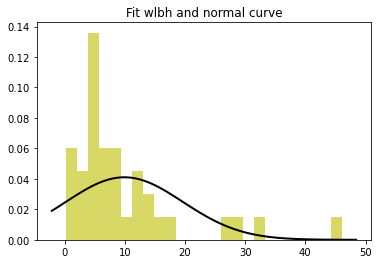

In [150]:
mu,std = stats.norm.fit(wlbh13)

plt.hist(wlbh13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit wlbh and normal curve"
plt.title(title)
plt.show()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

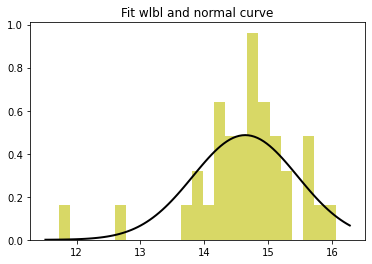

In [151]:
mu,std = stats.norm.fit(wlbl13)

plt.hist(wlbl13, bins=25, density = True, alpha=0.6, color = 'y')
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x,mu,std)
plt.plot(x,p,'k',linewidth = 2)
title = "Fit wlbl and normal curve"
plt.title(title)
plt.show()

In [164]:
stats.levene(df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==0].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==1].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==2].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==3].dropna(),center = 'mean')

##from levene test samples have diff variances, also obv by looking at norm plot and box plot


LeveneResult(statistic=3.4170750265178533, pvalue=0.0293699097420031)

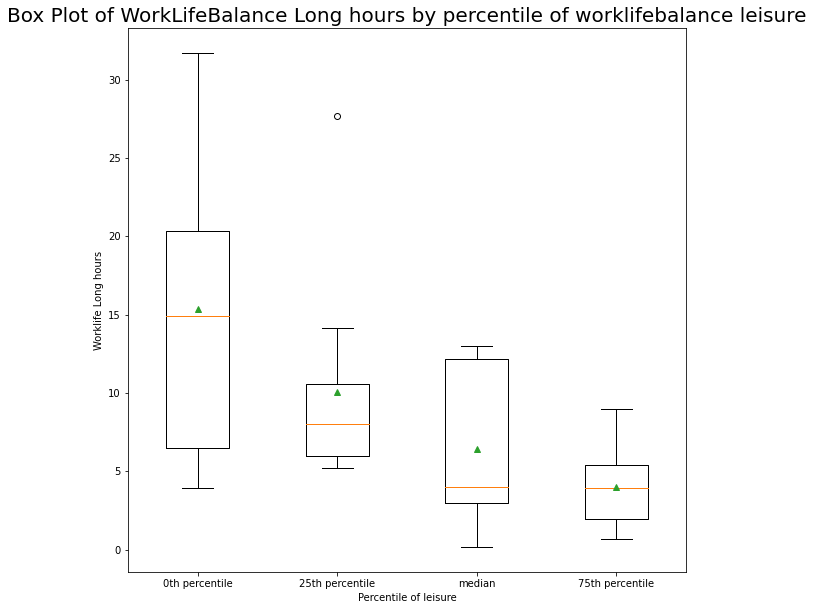

In [204]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of WorkLifeBalance Long hours by percentile of worklifebalance leisure", fontsize= 20)
ax.set

data = [df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==0].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==1].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==2].dropna(),
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==3].dropna()]

ax.boxplot(data,
           labels= ['0th percentile', '25th percentile', 'median','75th percentile'],
           showmeans= True)

plt.xlabel("Percentile of leisure")
plt.ylabel("Worklife Long hours")

plt.show()

In [203]:
from collections import namedtuple
def welch_anova_np(*args, var_equal=False):
    # https://svn.r-project.org/R/trunk/src/library/stats/R/oneway.test.R
    # translated from R Welch ANOVA (not assuming equal variance)

    F_onewayResult = namedtuple('F_onewayResult', ('statistic', 'pvalue'))

    args = [np.asarray(arg, dtype=float) for arg in args]
    k = len(args)
    ni =np.array([len(arg) for arg in args])
    mi =np.array([np.mean(arg) for arg in args])
    vi =np.array([np.var(arg,ddof=1) for arg in args])
    wi = ni/vi

    tmp =sum((1-wi/sum(wi))**2 / (ni-1))
    tmp /= (k**2 -1)

    dfbn = k - 1
    dfwn = 1 / (3 * tmp)

    m = sum(mi*wi) / sum(wi)
    f = sum(wi * (mi - m)**2) /((dfbn) * (1 + 2 * (dfbn - 1) * tmp))
    prob = stats.f.sf(dfbn, dfwn, f)
    return F_onewayResult(f, prob)

welch_anova_np(df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==0],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==1],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==2],
              df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==3])

F_onewayResult(statistic=4.535801531392996, pvalue=0.1291846282518893)

In [189]:
# from pingouin import pairwise_gameshowell
# datas =[df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==0].dropna(),
#               df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==1].dropna(),
#               df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==2].dropna(),
#               df['WorkLifeBalanceLongHours2013'][df['wlbl2013P']==3].dropna()]
# dataframe = pd.DataFrame(datas)
# print(dataframe)
# pairwise_gameshowell(data = dataframe,dv = 'WorkLifeBalanceLongHours2013')

                                 0     1     2     3     4      5     7   \
WorkLifeBalanceLongHours2013    NaN   NaN   NaN   NaN  3.91  16.32   NaN   
WorkLifeBalanceLongHours2013  14.13  8.76   NaN   NaN   NaN    NaN  7.58   
WorkLifeBalanceLongHours2013    NaN   NaN   NaN  12.5   NaN    NaN   NaN   
WorkLifeBalanceLongHours2013    NaN   NaN  4.43   NaN   NaN    NaN   NaN   

                                8    9     10  ...    28   29    30    31  \
WorkLifeBalanceLongHours2013   NaN  4.1   NaN  ...  7.24  NaN   NaN   NaN   
WorkLifeBalanceLongHours2013   NaN  NaN   NaN  ...   NaN  8.5   NaN  6.38   
WorkLifeBalanceLongHours2013   NaN  NaN  3.89  ...   NaN  NaN  0.16   NaN   
WorkLifeBalanceLongHours2013  1.97  NaN   NaN  ...   NaN  NaN   NaN   NaN   

                                32    34    35    36     38     39  
WorkLifeBalanceLongHours2013   NaN   NaN   NaN   NaN    NaN    NaN  
WorkLifeBalanceLongHours2013  5.55   NaN   NaN  5.87    NaN  11.13  
WorkLifeBalanceLongHours20

KeyError: 'WorkLifeBalanceLongHours2013'

In [197]:
# !pip install numpy-indexed
!pip install scikit_posthocs

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37886 sha256=82943a1903ec01c2b88a90c6630f9cc9727027f174150a53d14482e4d30a3a89
  Stored in directory: c:\users\lbowe\appdata\local\pip\cache\wheels\59\a1\76\8954a8efb2e143534be5943de94a245c673b25b9ce71c3aab3
Successfully built scikit-posthocs


In [205]:
from scikit_posthocs import posthoc_dunn

g1 = df['WorkLifeBalanceLongHours2013']
g2 = df['WorkLifeBalanceLeisure2013']
g3 = df['wlbl2013P']

data = [g1,g2,g3]

posthoc_dunn(data)

,1,2,3
1,1.000000,1.338583e-03,1.384361e-05
2,0.001339,1.000000e+00,5.026251e-14
3,0.000014,5.026251e-14,1.000000e+00
